In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_tweedie_deviance
from sklearn.metrics import zero_one_loss

import shap
import xgboost as xgb

In [58]:
shap.initjs()

In [59]:
df = pd.read_csv('../Data/Processed Dataset Train')

In [60]:
df.insert(31, "Media", np.where((df["Photo Count"] > 0) | (df["Video Count"] > 0) | (df["GIF Count"] > 0), 1, 0))
df.insert(32, "Emotion Score", df["Negative Score"] + df["Positive Score"])
df.insert(33, "Photo", np.where(df["Photo Count"] > 0, 1, 0))
df.insert(34, "Video", np.where(df["Video Count"] > 0, 1, 0))
df.insert(35, "GIF", np.where(df["GIF Count"] > 0, 1, 0))

In [61]:
df.iloc[:, :38].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46289 entries, 0 to 46288
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                46289 non-null  int64  
 1   date                              46289 non-null  object 
 2   hour of tweet                     46289 non-null  int64  
 3   time of day                       46289 non-null  object 
 4   Early Morning Count               46289 non-null  int64  
 5   Morning Count                     46289 non-null  int64  
 6   Noon Count                        46289 non-null  int64  
 7   Eve Count                         46289 non-null  int64  
 8   Night Count                       46289 non-null  int64  
 9   Late Night Count                  46289 non-null  int64  
 10  user                              46289 non-null  object 
 11  user_followers                    46289 non-null  int64  
 12  Mont

In [82]:
useful_list = [24, 25, 26, 11, 12, 15, 17, 23, 28, 29, 30, 33, 34, 35, 36]

In [83]:
df_small = df.iloc[:, useful_list]

In [84]:
X = df_small.iloc[:, 3:].join(df.iloc[:, 37:])
y = df_small.iloc[:, 1]

In [85]:
X.columns

Index(['user_followers', 'Months Since Creation of Account', 'Negative Score',
       'Positive Score', 'Subjectivity Score_textblob', 'tweet_length',
       'num_mentions', 'num_hashtags', 'Photo', 'Video', 'GIF', 'num_urls'],
      dtype='object')

Retweets partitioned into bins for discrete y outcome
- 0
- 1-5
- 6-20
- 21+

In [86]:
y_discrete = np.where(y == 0, 0,
             np.where((y >= 1) & (y <= 5), 1,
             np.where((y >= 6) & (y <= 20), 2, 3)))

In [87]:
pd.Series(y_discrete).value_counts()

0    28514
1    13803
2     2739
3     1233
dtype: int64

In [88]:
X_train, X_test, y_train, y_test, y_discrete_train, y_discrete_test = train_test_split(X, y, y_discrete, random_state = 0)

## XGBoost Tweedie Regression

In [89]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

In [90]:
params = {"objective":"reg:tweedie",'colsample_bytree': 1.0, 'learning_rate': 0.01,'gamma':1.5,'max_depth': 2,
 'subsample':0.6, 'reg_alpha': 0,'reg_lambda':1,'min_child_weight':5, 'tweedie_variance_power':1.5}

In [91]:
t0 = time.time()
bst = xgb.train(params, dtrain, num_boost_round = 1000)
t1 = time.time()
print(round(t1 - t0), 'seconds')

7 seconds


In [92]:
preds = bst.predict(dtest)
preds_int = np.round(preds).astype(int)

In [93]:
mean_tweedie_deviance(y_test, preds, power = 1.5)
#testing loss

5.089523543328208

In [94]:
preds_train = bst.predict(dtrain)
mean_tweedie_deviance(y_train, preds_train, power = 1.5)
#training loss

4.685082515342859

In [95]:
1 - zero_one_loss(y_test, preds_int)
#correctly predicts 31% of the test sample

0.31271061954549384

In [106]:
#zero recall
sum(np.multiply((preds_int == y_test), y_test == 0))/sum(y_test == 0)

0.38295165394402036

### Cross validation

In [96]:
# recall for predicting zeros
def zero_recall(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(preds).astype(int)
    recall = sum(np.multiply((preds == labels), labels == 0))/sum(labels == 0)
    return "zero_recall", recall

In [97]:
def zero_one_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(preds).astype(int)
    return "0-1_Accuracy", 1 - zero_one_loss(labels, preds)

In [115]:
t0 = time.time()
scores = xgb.cv(params, dtrain, nfold = 5, metrics = 'tweedie-nloglik@1.5',
                num_boost_round = 1000, as_pandas = True, custom_metric = zero_one_accuracy)
t1 = time.time()
print(round(t1-t0), 'seconds')

86 seconds


In [116]:
scores.iloc[-1]

train-tweedie-nloglik@1.5-mean    5.522127
train-tweedie-nloglik@1.5-std     0.025256
test-tweedie-nloglik@1.5-mean     5.666418
test-tweedie-nloglik@1.5-std      0.097975
train-0-1_Accuracy-mean           0.317635
train-0-1_Accuracy-std            0.003890
test-0-1_Accuracy-mean            0.315704
test-0-1_Accuracy-std             0.005454
Name: 999, dtype: float64

In [ ]:
#plt.plot(scores["test-tweedie-nloglik@1.5-mean"])
plt.plot(scores["test-zero_recall-mean"])
plt.show()

### Model interpretation

In [107]:
explainer_tweedie = shap.TreeExplainer(bst)
shap_values_tweedie = explainer_tweedie.shap_values(X)

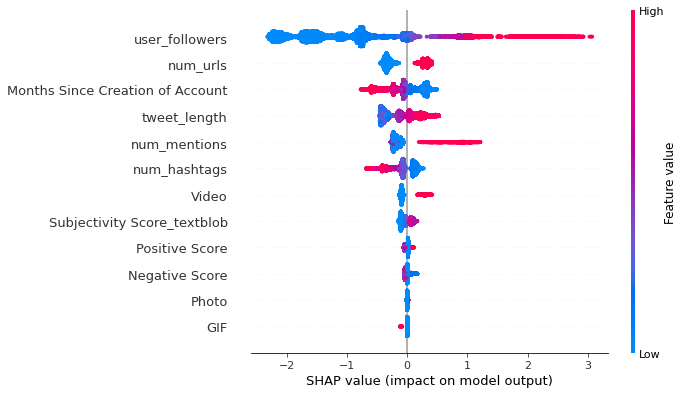

In [108]:
shap.summary_plot(shap_values_tweedie, X)

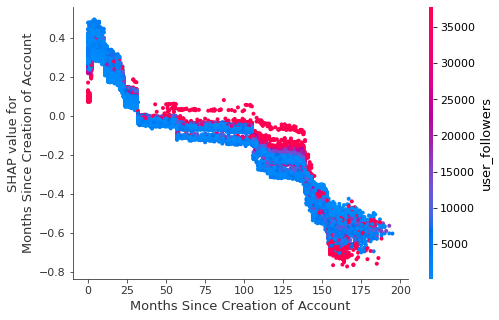

In [109]:
shap.dependence_plot('Months Since Creation of Account', shap_values_tweedie, X, interaction_index = 'user_followers')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


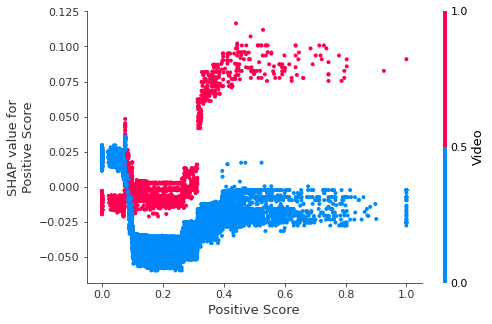

In [117]:
shap.dependence_plot('Positive Score', shap_values_tweedie, X)

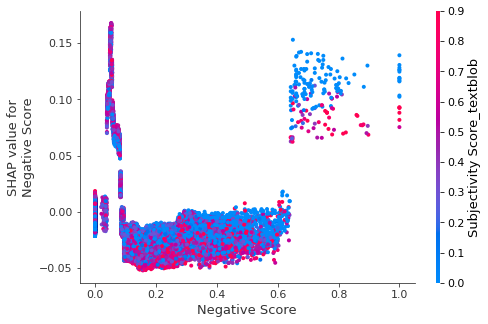

In [112]:
shap.dependence_plot('Negative Score', shap_values_tweedie, X, interaction_index = 'Subjectivity Score_textblob')

## XGBoost Discrete Outcome Bins Classification

In [29]:
dtrain_discrete = xgb.DMatrix(X_train, label = y_discrete_train)
dtest_discrete = xgb.DMatrix(X_test, label = y_discrete_test)

In [30]:
params = {'objective':'multi:softmax', 'num_class': 4}

In [31]:
t0 = time.time()
bst_discrete = xgb.train(params, dtrain_discrete, num_boost_round = 1000)
t1 = time.time()
print(round(t1-t0), 'seconds')

43 seconds


In [32]:
preds2 = bst_discrete.predict(dtest_discrete)
preds2_int = np.round(preds2).astype(int)

In [33]:
zero_one_loss(y_discrete_test, preds2)

0.33111552752095397

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_discrete_test, preds2)

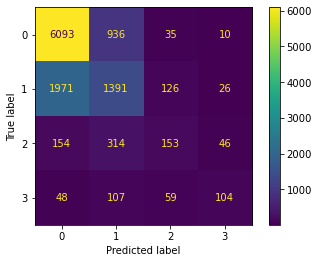

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay
display = ConfusionMatrixDisplay(cm)
display.plot()
plt.show()

In [36]:
explainer_discrete = shap.TreeExplainer(bst_discrete)
shap_values_discrete = explainer_discrete.shap_values(X)

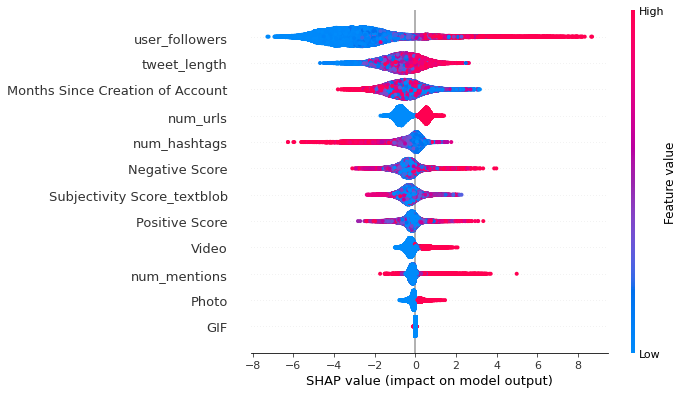

In [37]:
# look at feature impacts for having 21+ tweets
shap.summary_plot(shap_values_discrete[3], X)

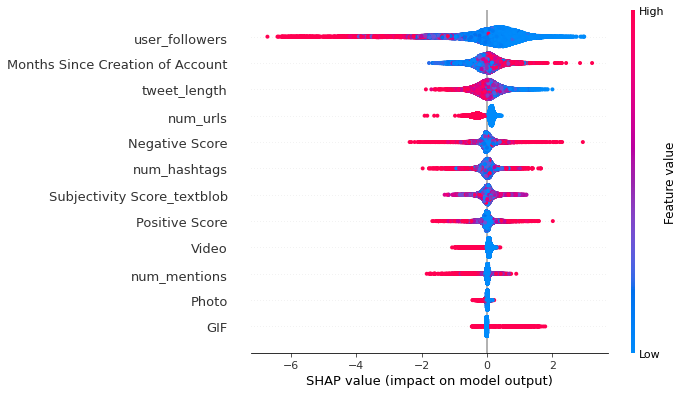

In [38]:
# look at feature impacts for having 0 tweets
shap.summary_plot(shap_values_discrete[0], X)

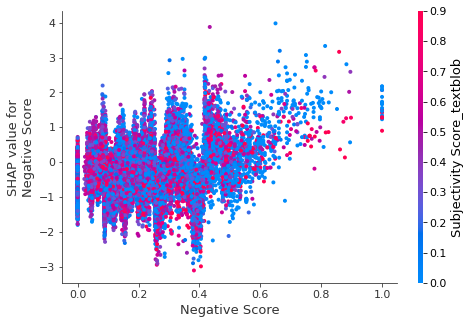

In [40]:
#for 21+ tweets, higher negative score weakly correlates with virality
shap.dependence_plot("Negative Score", shap_values_discrete[3], X, interaction_index='Subjectivity Score_textblob')